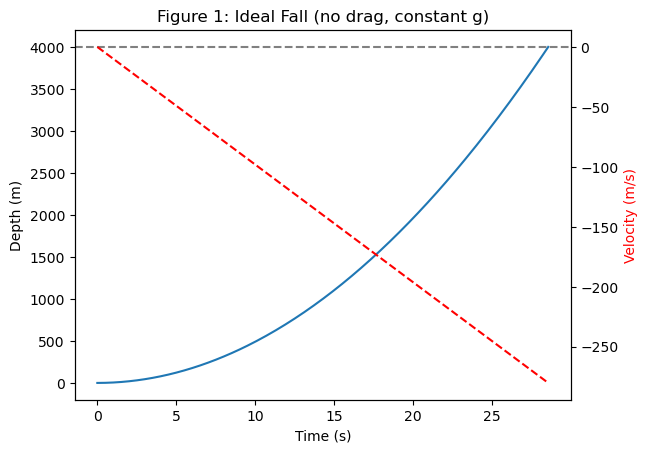

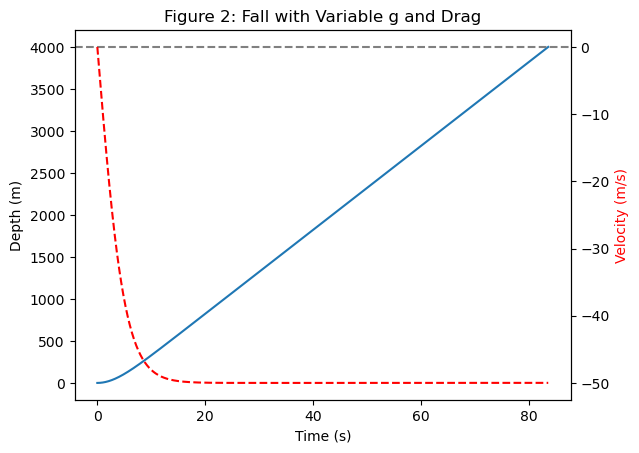

Fall time (ideal): 28.6 s
Fall time (var g + drag): 83.5 s


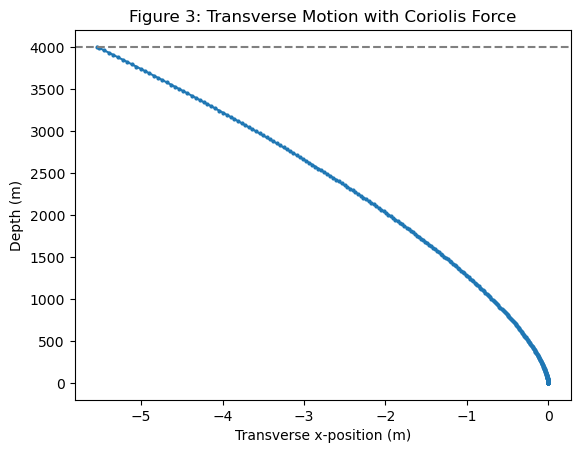

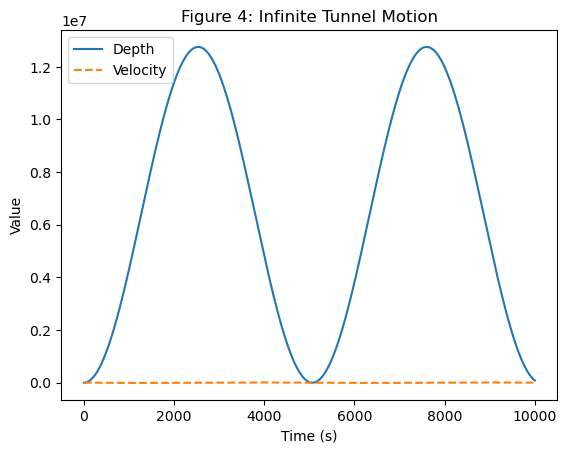

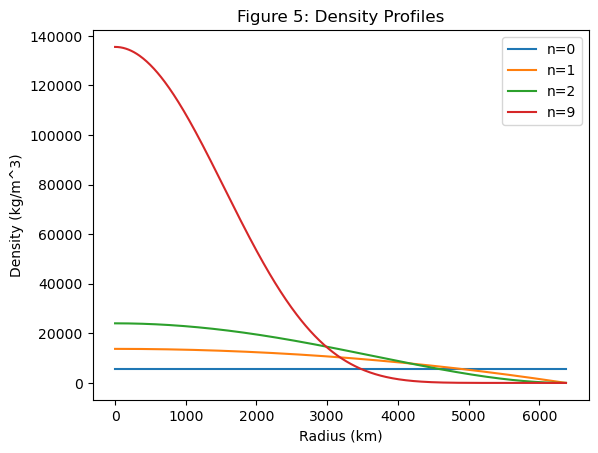

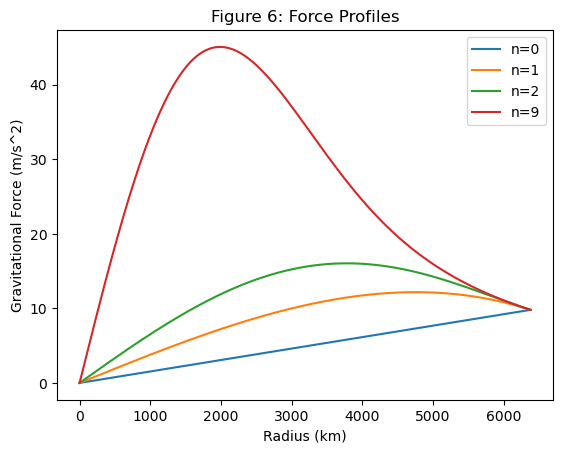

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, quad
import matplotlib.pyplot as plt

# Constants
G = 6.6743e-11  # m^3/kg/s^2
g0 = 9.81  # m/s^2
M_earth = 5.972e24  # kg
R_earth = 6.3781e6  # meters
shaft_depth = 4000  # meters
mass = 1.0  # kg
omega = 7.272e-5  # rad/s

#---------------------#
# Part 1: Ideal Case
#---------------------#

def fall_ideal(t, y):
    pos, vel = y
    dydt = [vel, -g0]
    return dydt

def hit_bottom(t, y, *args):
    return y[0] - (R_earth - shaft_depth)
hit_bottom.terminal = True
hit_bottom.direction = -1

# Initial conditions
y0 = [R_earth, 0]  # start at surface, 0 velocity
t_span = (0, 100)
sol = solve_ivp(fall_ideal, t_span, y0, events=hit_bottom, max_step=0.1)

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(sol.t, R_earth - sol.y[0], label='Depth')
ax2.plot(sol.t, sol.y[1], 'r--', label='Velocity')
ax1.axhline(shaft_depth, color='gray', linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('Velocity (m/s)', color='r')
plt.title('Figure 1: Ideal Fall (no drag, constant g)')
plt.show()

#------------------------------#
# Part 2: Variable g + Drag
#------------------------------#

def g_linear(r):
    return g0 * r / R_earth

def fall_var_g_drag(t, y, alpha, gamma):
    r, v = y
    drag = -alpha * np.abs(v)**gamma * np.sign(v)
    g = -g_linear(r)
    return [v, g + drag]

# Determine alpha for terminal velocity 50 m/s (gamma = 2)
v_terminal = 50
alpha = mass * g0 / v_terminal**2

y0 = [R_earth, 0]
t_span = (0, 200)
sol2 = solve_ivp(fall_var_g_drag, t_span, y0, args=(alpha, 2), events=hit_bottom, max_step=0.1)

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(sol2.t, R_earth - sol2.y[0], label='Depth')
ax2.plot(sol2.t, sol2.y[1], 'r--', label='Velocity')
ax1.axhline(shaft_depth, color='gray', linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('Velocity (m/s)', color='r')
plt.title('Figure 2: Fall with Variable g and Drag')
plt.show()

print(f"Fall time (ideal): {sol.t_events[0][0]:.1f} s")
print(f"Fall time (var g + drag): {sol2.t_events[0][0]:.1f} s")

#---------------------#
# Part 3: Coriolis Force
#---------------------#

def coriolis(t, y):
    x, y_pos, vx, vy = y
    ax = 2 * omega * vy
    ay = -g0 - 2 * omega * vx
    return [vx, vy, ax, ay]

def hit_bottom_y(t, y, *args):
    return y[1] - (R_earth - shaft_depth)
hit_bottom_y.terminal = True
hit_bottom_y.direction = -1

# Initial conditions: start from surface center of shaft
y0 = [0, R_earth, 0, 0]  # x, y, vx, vy
t_span = (0, 200)
sol3 = solve_ivp(coriolis, t_span, y0, events=hit_bottom_y, max_step=0.1)

# Plot transverse position vs. depth
plt.figure()
plt.plot(sol3.y[0], R_earth - sol3.y[1], 'o-', markersize=2)
plt.axhline(shaft_depth, color='gray', linestyle='--')
plt.xlabel('Transverse x-position (m)')
plt.ylabel('Depth (m)')
plt.title('Figure 3: Transverse Motion with Coriolis Force')
plt.show()

#---------------------#
# Part 4: Infinite Tunnel
#---------------------#

def tunnel(t, y):
    r, v = y
    g = -g0 * r / R_earth
    return [v, g]

def hit_center(t, y):
    return y[0]
hit_center.terminal = False
hit_center.direction = 0

# Full tunnel through Earth
y0 = [R_earth, 0]
t_span = (0, 10000)
sol4 = solve_ivp(tunnel, t_span, y0, events=hit_center, max_step=1)

# Plot
plt.figure()
plt.plot(sol4.t, R_earth - sol4.y[0], label='Depth')
plt.plot(sol4.t, sol4.y[1], '--', label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.title('Figure 4: Infinite Tunnel Motion')
plt.show()

#---------------------#
# Part 5: Non-uniform Earth
#---------------------#

def density_profile(r, n):
    return (1 - (r/R_earth)**2)**n

def mass_integral(n):
    integrand = lambda r: density_profile(r, n) * r**2
    return 4 * np.pi * quad(integrand, 0, R_earth)[0]

# Normalizing constant
rho_n_dict = {n: M_earth / mass_integral(n) for n in [0, 1, 2, 9]}
r_vals = np.linspace(0, R_earth, 500)

# Plot density profiles
plt.figure()
for n in [0, 1, 2, 9]:
    rho = rho_n_dict[n] * density_profile(r_vals, n)
    plt.plot(r_vals / 1e3, rho, label=f'n={n}')
plt.xlabel('Radius (km)')
plt.ylabel('Density (kg/m^3)')
plt.title('Figure 5: Density Profiles')
plt.legend()
plt.show()

# Gravitational force profiles
plt.figure()
for n in [0, 1, 2, 9]:
    rho_n = rho_n_dict[n]
    force = []
    for r in r_vals:
        m_enc = 4*np.pi * quad(lambda x: rho_n * density_profile(x, n) * x**2, 0, r)[0]
        g = G * m_enc / r**2 if r > 0 else 0
        force.append(g)
    plt.plot(r_vals / 1e3, force, label=f'n={n}')
plt.xlabel('Radius (km)')
plt.ylabel('Gravitational Force (m/s^2)')
plt.title('Figure 6: Force Profiles')
plt.legend()
plt.show()